In [1]:
import librosa
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np

In [2]:
from root.common.feeder import input_feeder

In [3]:
data = input_feeder().iterator

In [4]:
mel, inpt, labels = data.get_next()

In [5]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [6]:
session.run(data.initializer)

In [7]:
mel.set_shape([None, 64])
dense_mel = tf.layers.dense(mel, units=256)

In [8]:
dense_mel_flattened = tf.reshape(dense_mel, [-1])

In [9]:
c_1 = tf.pad(inpt[0][:-1], [[1, 0]])
f_1 = tf.pad(inpt[1][:-1], [[1, 0]])

coarse_input = tf.stack([c_1, f_1, dense_mel_flattened], axis=-1)

fine_input = tf.stack([c_1, f_1, inpt[0]], axis=-1)


In [10]:
seq_length = 1024
coarse_shape = tf.shape(coarse_input)[0]
controller = coarse_shape - tf.mod(coarse_shape, seq_length)

coarse_controlled = tf.transpose(tf.reshape(coarse_input[:controller], [-1, seq_length, 3]), [1,0,2])
fine_controlled = tf.transpose(tf.reshape(fine_input[:controller], [-1, seq_length, 3]), [1,0,2])

In [11]:
with tf.variable_scope("temp", reuse=tf.AUTO_REUSE):
    coarse_cell = tf.contrib.cudnn_rnn.CudnnGRU(
        num_units=128, num_layers=2)
    coarse_output, _ = coarse_cell(coarse_controlled)
    coarse_output = tf.layers.dense(coarse_output, units=256)

with tf.variable_scope("temp", reuse=tf.AUTO_REUSE):
    fine_cell = tf.contrib.cudnn_rnn.CudnnGRU(
        num_units=128, num_layers=2)
    fine_output, _ = fine_cell(fine_controlled)
    fine_output = tf.layers.dense(fine_output, units=256)

In [12]:
labels = tf.reshape(labels[:,:controller], [2, -1, seq_length])
coarse_labels = tf.transpose(tf.one_hot(labels[0], depth=256), [1,0,2])[-800:]
fine_labels = tf.transpose(tf.one_hot(labels[1], depth=256), [1,0,2])[-800:]

c_loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(logits=coarse_output[-800:],
                                                                   labels=coarse_labels))
f_loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(logits=fine_output[-800:],
                                                                   labels=fine_labels))


In [13]:
optimizer = tf.train.AdadeltaOptimizer(learning_rate=0.9).minimize((c_loss+f_loss)/2)

In [14]:
global_var = tf.global_variables_initializer()
session.run(global_var)

In [15]:
saver = tf.train.Saver()
saver.save(session, "./5_02_pm_")

'./5_02_pm_'

In [16]:
av_loss = list()

In [ ]:
seq = tqdm(2318)
while(True):
    try:
        session.run([optimizer])
        seq.update()
    except tf.errors.OutOfRangeError:
        session.run(data.initializer)
        closs,floss=session.run([c_loss,f_loss])
        av_loss.append([closs, floss])
        seq.set_postfix(
            {"loss": np.mean(av_loss, axis=0)})
        continue

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [25]:
outp = session.run([tf.nn.softmax(coarse_output),tf.nn.softmax(fine_output), labels[0], labels[1]])
coarse_outp = np.reshape(np.transpose(outp[0], [1,0,2]), [-1, 256])
coarse_gt = np.reshape(outp[2], [-1])
# fine_outp = outp[1]
# fine_gt = outp[3]
coarse_outp = np.argmax(coarse_outp, axis=-1)
# fine_outp = np.argmax(fine_outp, axis=-1)

# coarse_outp = np.reshape(coarse_outp,[-1])
# fine_outp = np.reshape(fine_outp,[-1])

# coarse_gt = np.reshape(coarse_gt,[-1])
# fine_gt = np.reshape(fine_gt,[-1])

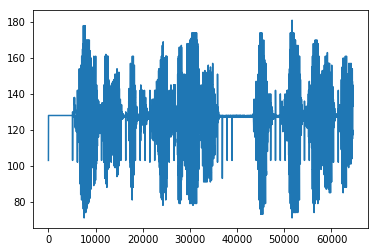

In [26]:
plt.plot(coarse_outp)

In [21]:
coarse_outp.shape

(65536,)

In [22]:
# # first = 0
# # second = 13900
# # plt.plot(coarse_outp[:])
# # plt.plot(coarse_gt[:])
# plt.plot(fine_outp[20000:20100])
# plt.plot(fine_gt[20000:20100])

In [23]:
print(len(np.where(fine_gt==fine_outp)[0])/len(coarse_gt))
print(len(np.where(coarse_gt==coarse_outp)[0])/len(coarse_gt))

NameError: name 'fine_gt' is not defined

In [ ]:
coarse_gt.shape

In [ ]:
plt.plot(av_loss)

In [ ]:
fine = fine_gt
coarse = coarse_gt

In [ ]:
coarse*=255

In [ ]:
coarse+=fine

In [ ]:
plt.plot(coarse)

In [ ]:
avv_loss = np.asarray(av_loss)

In [ ]:
plt.plot(avv_loss[:,1])

In [ ]:
av_loss[-2:]

In [ ]:
saver = tf.train.Saver()

In [ ]:
saver.save(session, "./5_02_pm_")

In [ ]:
session.run(tf.shape(labels))

In [ ]:
session.run([tf.shape(coarse_output[:,-800:]), tf.shape(coarse_labels)])

In [ ]:
session.run(tf.shape(coarse_labels))

In [ ]:
state = dir(coarse_cell)

In [27]:
coarse_cell.__call__()

TypeError: __call__() missing 1 required positional argument: 'inputs'

In [31]:
tensor = tf.reshape(np.arange(27),[3,3,3])

In [38]:
mask = tf.boolean_mask(tensor, [False, True, True], axis=2)

In [39]:
session.run(tensor)

array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]],

       [[ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]],

       [[18, 19, 20],
        [21, 22, 23],
        [24, 25, 26]]])

In [40]:
session.run(mask)

array([[[ 1,  2],
        [ 4,  5],
        [ 7,  8]],

       [[10, 11],
        [13, 14],
        [16, 17]],

       [[19, 20],
        [22, 23],
        [25, 26]]])